In [98]:
%matplotlib inline
import pdb, glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utmLib import utils

import tinylib
from functools import partial
from collections import defaultdict

# plt.rcParams['figure.figsize'] = [10, 5]
np.set_printoptions(suppress=True, linewidth=120, precision=4)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

def drop_side(arr, drop = 0):
    if drop > 0:
        best_cut, worst_cut = np.percentile(arr, [drop/2, 100-drop/2])
        best_cut_idx = arr < best_cut
        worst_cut_idx = arr > worst_cut
        arr[best_cut_idx] = np.nan
        arr[worst_cut_idx] = np.nan
        arr = arr[~np.isnan(arr)]
    return arr

def sequence_RMSE(truth, pred, mask, drop = 0):
    diff = abs(truth[mask] - pred[mask]) ** 2
    diff = drop_side(diff, drop = drop)
    return np.sqrt( diff.mean() )
    
def sequence_within(truth, pred, mask, thresh, fixed = False, eps = 1e-2):
    if fixed:
        max_diff = thresh
    else:
        max_diff = np.maximum(abs(truth[mask]), eps) * thresh / 100
    diff = abs(truth[mask] - pred[mask])
    num_in = ( diff <= max_diff ).sum()
    total = diff.size
    return (num_in/total)*100

# average metric over all sequence 
def average_stat(truth, pred, mask, func):
    tmp = [func(t,p,m) for t,p,m in zip(truth, pred, mask)]
    return np.mean(tmp)

def scikit_wrapper(truth, pred, mask, method):
    return method(truth[mask],pred[mask])

# Mean absolute scaled error, this is not a good measure for trajectory prediction task
def sequence_MASE(truth, pred, mask):
    mase = np.mean(abs(truth[mask] - pred[mask])) / np.mean(abs(truth[1:] - truth[0:-1]))
    return mase
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


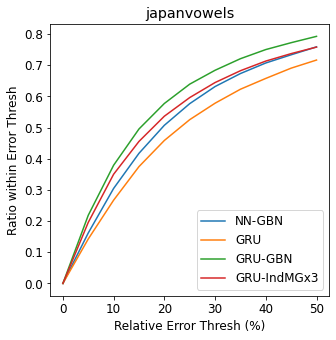

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


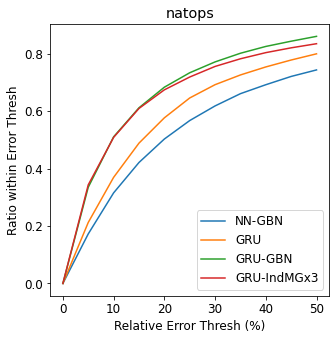

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


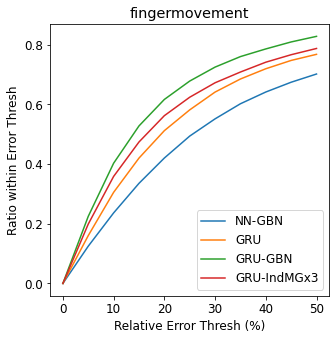

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


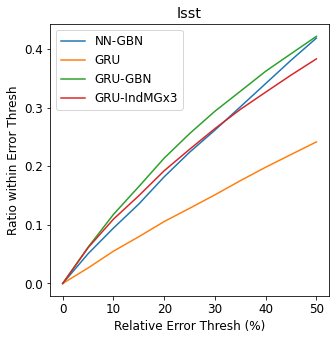

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


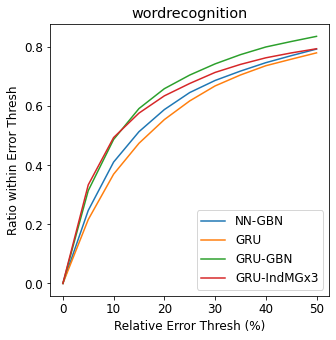

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


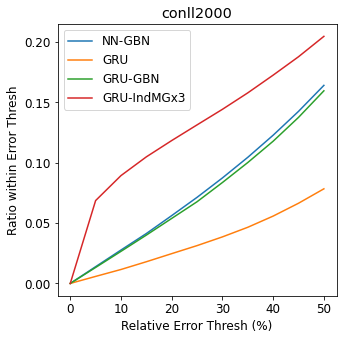

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


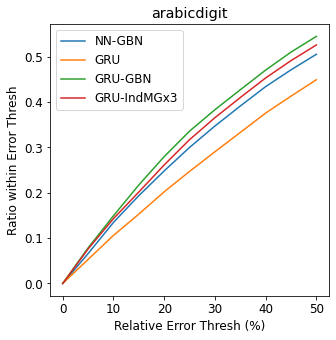

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


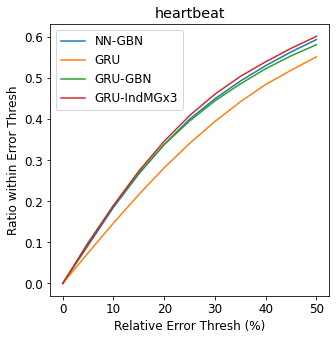

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


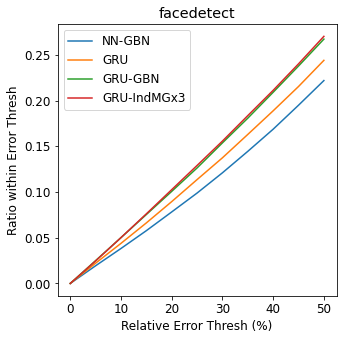

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


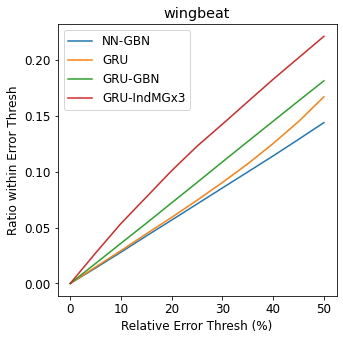

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


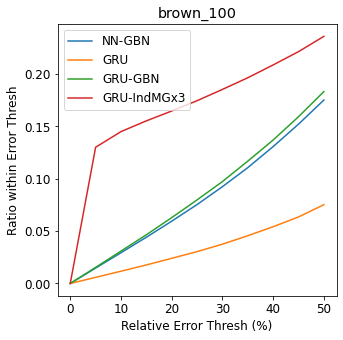

In [103]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, median_absolute_error, auc

# exp_name = 'trajectory'
exp_name = 'seqcomp'
data_names = 'japanvowels natops fingermovement lsst wordrecognition conll2000 \
              arabicdigit heartbeat facedetect wingbeat brown_100'
data_names = data_names.split()
max_isin = 50
results = defaultdict(dict)
metrics = []

# sklearn metrics 
for name, method in zip(['MAPE','MAE','MdAE'], 
                        [mean_absolute_percentage_error, mean_absolute_error, median_absolute_error]):
    metrics.append( (name, partial(scikit_wrapper, method = method)) )

# is-in metrics
for t in range(5, max_isin+1, 5):
    metrics.append( (f'ISIN-{t}%', partial(sequence_within, thresh = t, fixed = False) ) )    
metrics.append( ('MRAR', None) )  # this metric must after all ISIN-metric

# main logic
plt.rcParams.update({'font.size': 12})
name_map = {'NN-MG':'NN-GBN', 'RNN-STD':'GRU', 'RNN-MG':'GRU-GBN', 'RNN-IndMGx3':'GRU-IndMGx3'}
all_models = ['NN-MG', 'RNN-STD', 'RNN-MG', 'RNN-IndMGx3'] # custom order
all_models = [name_map[x] for x in all_models]

for name in data_names:
    train, test = utils.pkload(f'./data/{name}/seqs.fdt')
    train, test = tinylib.standardize_TS(train, test, method = 'std')
    test = test[:300]
    all_pred = utils.pkload(f'./results/{exp_name}/{name}/preds.pkl')
    for k in list(all_pred.keys()):
        all_pred[name_map[k]] = all_pred[k]
        del all_pred[k]
    # all_models = sorted(all_pred.keys())
    
    # reconstruct the prediction mask
    pred_mask = []
    for i,p in enumerate(all_pred['NN-GBN']):
        g = test[i]
        mask = np.where(p != g)
        pred_mask.append(mask)
    
    # eval for each metric
    for metric_name, metric_func in metrics:
        curve_data = {}
        for model_name in all_models:
            model_pred = all_pred[model_name]
            if model_name not in results[metric_name]:
                results[metric_name][model_name] = []
            
            if metric_name != 'MRAR':
                results[metric_name][model_name].append( average_stat(test, model_pred, pred_mask, metric_func) )
            else:
                Y = [0]
                for t in range(5,max_isin+1,5):
                    Y.append( results[f'ISIN-{t}%'][model_name][-1] / 100.0 )
                X = range(0,max_isin+1,5)
                curve_data[model_name] = (X,Y)
                results[metric_name][model_name].append( auc(X,Y) )
        
        if metric_name == 'MRAR':
            # plot all ? relative accuracy of regression ? curve into a single graph
            fid = plt.figure(figsize = [5,5])
            for i,model_name in enumerate(all_models):
                X,Y = curve_data[model_name]
                plt.plot(X, Y, label = model_name)

            fig_title = name
            plt.title(fig_title)
            plt.legend()
            plt.xlabel('Relative Error Thresh (%)')
            plt.ylabel('Ratio within Error Thresh')
            plt.savefig(f'./results/visualize/{exp_name}_{fig_title}.eps',  bbox_inches = 'tight')
            plt.show()
            

In [96]:
# calculate the relative performance
for metric in results:
    for k,v in results[metric].items():
        results[metric][k] = np.array(v)

all_metric = []
df_parts = []
for metric in results:
    ans = []
    if 'LL' in metric:
        continue
    if 'ISIN' in metric:
        continue
    
    all_metric.append(metric)
    n = len(results[metric])
    base = results[metric]['NN-GBN']
    for model in all_models:
        perf = np.mean(results[metric][model] / base)
        if 'E' in metric:
            perf = 1.0/perf
        ans.append(perf - 1)
    
    df = pd.DataFrame(results[metric]).T
    df = df.reset_index()
    df.columns = ['model'] + data_names
    df['R.Perf.'] = ans
    df['metric'] = [metric] * n
    df = df[['metric', 'model'] + data_names + ['R.Perf.'] ] 
    df_parts.append(df)
    # print(('{:.4f} ' * n) .format(*ans))

df = pd.concat(df_parts)
df = df.set_index(['metric', 'model'])
df.to_csv('temp.csv')
df[["R.Perf."]]
df

japanvowels     natops  fingermovement       lsst  wordrecognition  conll2000  arabicdigit  heartbeat  facedetect   wingbeat  brown_100   R.Perf.
metric model                                                                                                                                                         
MAPE   NN-GBN          1.540269   3.170353        3.859954   2.747291         1.147534   1.490338     3.492738   3.728904    4.597113  17.916838   2.129287  0.000000
       GRU             2.331221   3.008724        1.570531   8.938970         0.870394   1.752901     3.322309   3.536005    5.978504  14.130303   1.673785 -0.142803
       GRU-GBN         1.519834   1.242324        1.398675   3.237523         0.770876   2.178213     4.057648   3.534903    4.881505  17.504677   2.539767  0.058297
       GRU-IndMGx3     1.492894   1.729752        1.841443   2.296077         0.898517   4.366512     3.473381   3.222008    6.659272   2.323474   4.521826 -0.090981
MAE    NN-GBN          0.262026   0.155557        0.316442   0.413289         0.286294   0.803443     0.527866   0.355696    0.548012   0.273864   0.820012  0.000000
       GRU             0.223742   0.108952        0.152624   0.471601         0.225711   0.797116     0.464445   0.298269    0.511740   0.206653   0.793729  0.178619
       GRU-GBN         0.231716   0.100112        0.129910   0.425000         0.211531   0.838481     0.498912   0.358292    0.518051   0.251400   0.834669  0.147883
       GRU-IndMGx3     0.226067   0.097484        0.206813   0.416096         0.219215   0.976204     0.467116   0.340998    0.541856   0.205011   0.938999  0.116007
MdAE   NN-GBN          0.214768   0.124064        0.261132   0.274469         0.188634   0.665425     0.430277   0.228356    0.415269   0.103161   0.682115  0.000000
       GRU             0.178811   0.080323        0.122974   0.347311         0.145249   0.663176     0.379178   0.199330    0.386156   0.070613   0.654799  0.181345
       GRU-GBN         0.185199   0.076767        0.099331   0.282100         0.128029   0.704600     0.409232   0.235536    0.389045   0.090928   0.694445  0.164546
       GRU-IndMGx3     0.182237   0.075377        0.113451   0.261087         0.118809   0.800184     0.377268   0.214465    0.412947   0.066224   0.747272  0.192800
MRAR   NN-GBN          8.713657  16.497024        6.741667  21.047685        11.093519   2.625861     4.364530  12.851459    4.834510  20.901912   2.496833  0.000000
       GRU            10.531944  21.650794       13.543750  11.147222        14.160185   2.615000     5.129060  12.518066    4.798129  26.576089   2.683917  0.165459
       GRU-GBN        10.409722  23.398479       16.761905  22.501389        16.129321   2.451944     4.648932  11.366120    4.738002  23.177052   2.446028  0.234018
       GRU-IndMGx3    10.341898  24.022156       14.861905  23.466204        17.196605   4.212306     5.191453  14.054615    4.337249  27.958557   6.005889  0.458177

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


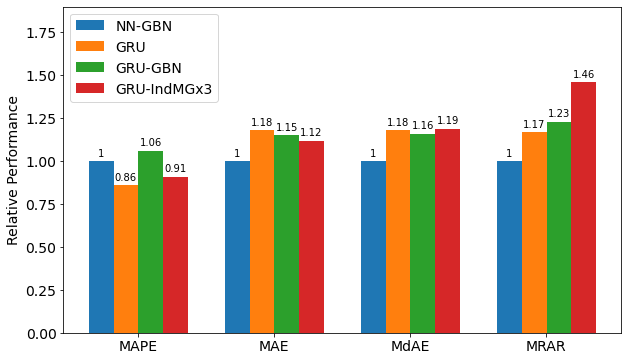

In [97]:
plt.rcParams.update({'font.size': 14})
data = df["R.Perf."] + 1
data = data.round(2)
group_name = all_metric
label_name = all_models
bar_width = 0.4
sep_width = 1.5*bar_width
n_bars = len(all_models)
start = np.array([(i+1)*sep_width + (bar_width)*n_bars*i  for i in range(len(group_name))])

fig,ax = plt.subplots(figsize = [10,6])
for i,name in enumerate(label_name):
    rect = ax.bar(start + i*(bar_width), data.loc[(slice(None),name)], bar_width, label = name)
    ax.bar_label(rect, padding = 3, fontsize =10)

ax.legend()
plt.ylim([0,1.9])
# ax.set_title('Title')
ax.set_ylabel('Relative Performance')
ax.set_xticks(start + (bar_width * n_bars / 2) - 0.21, group_name)
plt.savefig(f'./results/visualize/{exp_name}_all.eps')
plt.show()

In [ ]:
# this cell is used for parse and format the results
def parse_output(content, col_names, pattern = ['DGB', 'RNN', 'NN-']):
    info = {}
    for line in content:
        if line[:3] in pattern and 'elapsed time' not in line:
            tokens = line.strip().split(':')
            assert(len(tokens) == 2)
            
            k = tokens[0]
            v = tokens[1]
            if k not in info:
                info[k] = []
            info[k].append(v)

    index = []
    data = []

    for k,v in info.items():
        row = []
        for item in v:
            tokens = item.split(' ')
            mean = float(tokens[8])
            std = float(tokens[10])
            row.append(f'{mean} ± {std}')
        data.append(row)
        _n, _t = k.split(' ')
        index.append( _t + ' ' + _n )
    
    df = pd.DataFrame(data, index= index, columns = col_names).sort_index()
    return df

################################################################################################
exp_name = 'trajectory'
data_names = 'japanvowels natops fingermovement lsst wordrecognition conll2000 \
              arabicdigit heartbeat facedetect wingbeat brown_100'
col_names = data_names.split()
result_dir = f'{base_dir}/{exp_name}/'

# readin all output file contents
file_contents = []
for n in col_names:
    with open(f'{result_dir}/{n}/outputs.txt') as f:
        file_contents += f.readlines()

# parse the output as pandas table 
df = parse_output(file_contents, col_names)
df.to_csv('temp.csv')
df


In [ ]:
# this block is used for analysis the image files
result_dir = f'{base_dir}/std_0719/'
image_files = glob.glob(f'{result_dir}/*.jpg')

for imfile in image_files:
    if 'japanvowels' in imfile:
        img = plt.imread(imfile)
        plt.imshow(img)
        plt.show()
    

In [21]:
# this cell used for check dataset information
import os
import numpy as np
from utmLib import utils

def show_dataset_info(data):
    dim = data[0].shape[1]
    N = len(data)
    seq_len = [item.shape[0] for item in data]
    maxL = np.max(seq_len)
    minL = np.min(seq_len)
    avgL = int(np.round(np.mean(seq_len)))
    print(' Seqs:{} Dim:{} Len. Avg:{} Min:{} Max:{} #:{:.3f}'.format(N,dim,
        avgL,minL,maxL,np.log(N*dim*avgL)))
    
for name in os.listdir('./data'):
    if '_200' in name or 'gen_all' in name:
        continue
    
    fpath = './data/{}/seqs.fdt'.format(name)
    train, test = utils.pkload(fpath)
    D = train[0].shape[1]
    
    print(f'{name} train')
    show_dataset_info(train)
    print(f'{name} test')
    show_dataset_info(test)
    print('-'*60)

heartbeat train
 Seqs:176 Dim:61 Len. Avg:405 Min:405 Max:405 #:15.285
heartbeat test
 Seqs:183 Dim:61 Len. Avg:405 Min:405 Max:405 #:15.324
------------------------------------------------------------
japanvowels train
 Seqs:270 Dim:12 Len. Avg:16 Min:7 Max:26 #:10.856
japanvowels test
 Seqs:370 Dim:12 Len. Avg:15 Min:7 Max:29 #:11.106
------------------------------------------------------------
arabicdigit train
 Seqs:6599 Dim:13 Len. Avg:40 Min:9 Max:93 #:15.049
arabicdigit test
 Seqs:2200 Dim:13 Len. Avg:40 Min:7 Max:83 #:13.950
------------------------------------------------------------
facedetect train
 Seqs:2933 Dim:144 Len. Avg:62 Min:62 Max:62 #:17.081
facedetect test
 Seqs:996 Dim:144 Len. Avg:62 Min:62 Max:62 #:16.001
------------------------------------------------------------
natops train
 Seqs:180 Dim:14 Len. Avg:51 Min:51 Max:51 #:11.764
natops test
 Seqs:180 Dim:14 Len. Avg:51 Min:51 Max:51 #:11.764
------------------------------------------------------------
lsst trai

In [ ]:
# set all seed of commonly used libraries 
import torch, random
import numpy as np

my_seed = 0
torch.manual_seed(my_seed)
random.seed(my_seed)
np.random.seed(my_seed)
torch.cuda.manual_seed_all(my_seed)